Goal: Train and test a Linear Regression model using features: Bednights, Region, HHSize, HHEmployed, HHTANF, and slotted along with group: FamilyID to be able to predict bednights. Evaluate and iterate model.

In [1]:
##Load Modules for Regression Analysis training and testing
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import set_config
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
##Load Data, first inspection, create dummies for RegionCode
reg1 = pd.read_csv("C:/Users/morel/Downloads/Training Data 7-4-2025.csv")
reg1_dummies = pd.get_dummies(reg1, columns=['RegionCode','Destination'], dtype=int)
print(reg1_dummies.head(5))

   FamilyID  ResidentID  Bednights  HHSize  HHEmployed  HHTANF  Slotted  \
0       243         957        957       4           1       0        0   
1       243         958        957       4           1       0        0   
2       243         959        957       4           1       0        0   
3       243         960        957       4           1       0        0   
4       242         973        944       3           1       0        1   

   SlottedCCM  SlottedPME  SingleMom  ...  Destination_2  Destination_3  \
0           0           0          0  ...              0              0   
1           0           0          0  ...              0              0   
2           0           0          1  ...              0              0   
3           0           0          0  ...              0              0   
4           1           0          0  ...              0              0   

   Destination_4  Destination_5  Destination_6  Destination_7  Destination_8  \
0              0  

In [3]:
##EDA: no missing expected. No duplicates expected.
reg1_dummies.isna().sum()

FamilyID          0
ResidentID        0
Bednights         0
HHSize            0
HHEmployed        0
HHTANF            0
Slotted           0
SlottedCCM        0
SlottedPME        0
SingleMom         0
SingleDad         0
SingleParent      0
Disability        0
RegionCode_1      0
RegionCode_2      0
RegionCode_3      0
RegionCode_4      0
RegionCode_5      0
Destination_1     0
Destination_2     0
Destination_3     0
Destination_4     0
Destination_5     0
Destination_6     0
Destination_7     0
Destination_8     0
Destination_9     0
Destination_10    0
Destination_11    0
dtype: int64

In [4]:
reg1_dummies.duplicated().any()

False

In [6]:
##EDA: descriptive stattistics.
##FamilyID and ResidentID aren't interpretable.
##Each individual stayed at the facility for an average of 500 nights, for a median of 399. 50% of people stayed for 399 nights,
##some people stayed for many fewer nights, a minimum of 80 nights, skewing the average low. The standard deviation is also high.
##Regioncode is categorical. However, 50% of people are from region 1.
##50% of families have 4 people. On average, each family has 4.5 members.
##HHEmployed is categorical (yes/no). However, over 50% of households have at least one employed adult. This is supported by the average,
##showing 70% of households have at least one employed adult.
##HHTANF is categorical (yes,no). However, 50% of households have no members that receive TANF. This is supported by the average,
##showing that 40% of households have a member (or more) recieving TANF.
##Slotted is categorical (yes/no). However, 50% of families were slotted before they moved out. This is supported by the average,
##showing that about 60% of families were slotted before they move out.
reg1_dummies.describe()

,FamilyID,ResidentID,Bednights,HHSize,HHEmployed,HHTANF,Slotted,SlottedCCM,SlottedPME,SingleMom,...,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6,Destination_7,Destination_8,Destination_9,Destination_10,Destination_11
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,466.946078,1778.686275,500.367647,4.436275,0.710784,0.455882,0.642157,0.406863,0.235294,0.088235,...,0.029412,0.284314,0.019608,0.161765,0.019608,0.024510,0.083333,0.034314,0.009804,0.205882
std,139.633870,468.094197,300.293973,1.597676,0.454514,0.499275,0.480545,0.492457,0.425226,0.284335,...,0.169373,0.452197,0.138989,0.369141,0.138989,0.155006,0.277065,0.182482,0.098771,0.405340
min,223.000000,957.000000,80.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,301.500000,1197.750000,278.250000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,533.000000,2040.500000,399.000000,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,575.250000,2115.250000,807.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,596.000000,2201.000000,1063.000000,9.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
##Regression analysis: predicto move out date - prepare data
x = reg1_dummies.drop(columns=['Bednights','FamilyID','ResidentID','Destination_1']) ##features doesn't include target values: bednights, or FamilyID (not a feature)
y = reg1_dummies['Bednights']                                        ##target values
groups = reg1_dummies['FamilyID']                                    ##groupding varible for GroupKFOld to mitigate autocorrelation, keeps all members of the 
                                                             ##same family together to not make the model seem better than it actually is

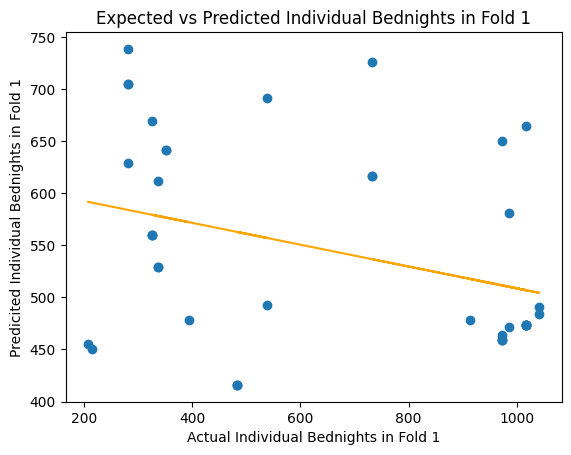

Fold 1 - MSE: 140358.5613, RMSE: 374.6446, R^2: -0.4114155689728509


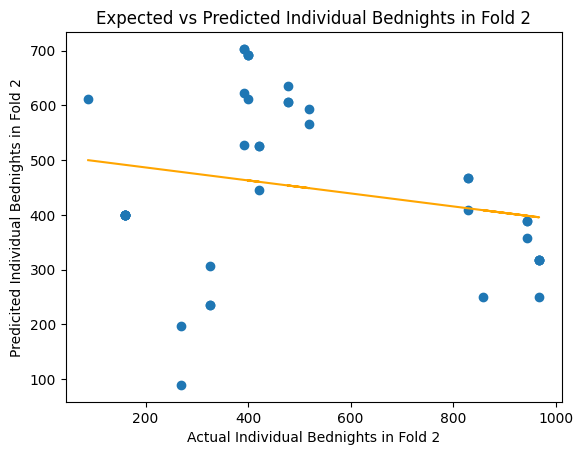

Fold 2 - MSE: 130976.8558, RMSE: 361.9072, R^2: -0.5661079528345272


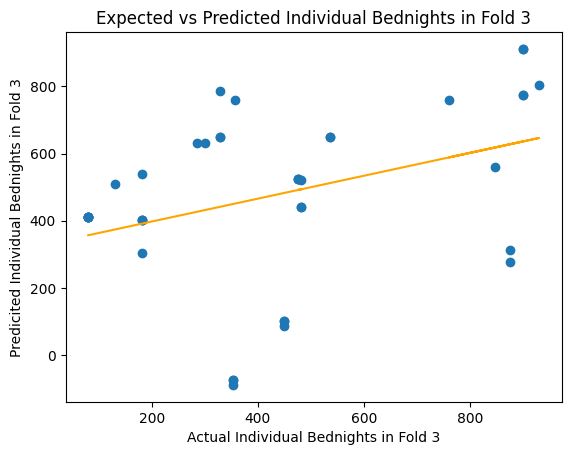

Fold 3 - MSE: 89564.2767, RMSE: 299.2729, R^2: -0.19185567066754694


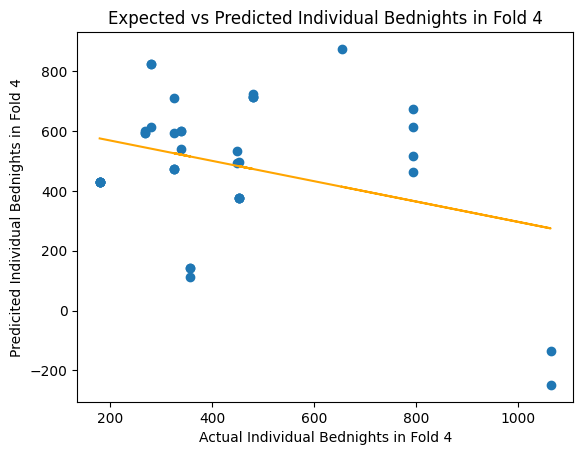

Fold 4 - MSE: 139156.2597, RMSE: 373.0365, R^2: -1.839259775740731


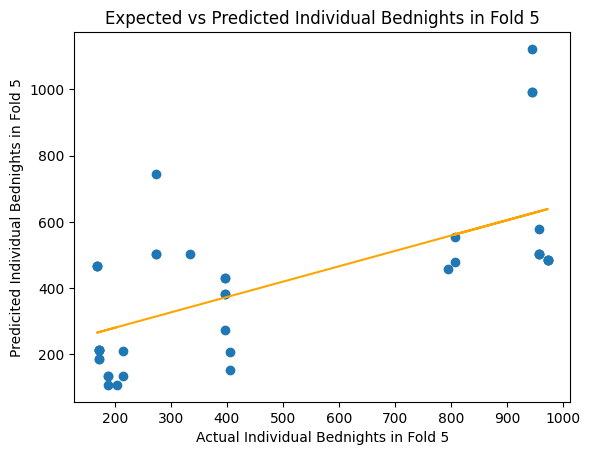

Fold 5 - MSE: 70442.2110, RMSE: 265.4095, R^2: 0.3556471641041018


<Figure size 640x480 with 0 Axes>

In [8]:
##Regression Analysis: predict move out date
##create folds
gkf = GroupKFold(n_splits = 5)

##split the data in each fold
for fold, (train_idx, test_idx) in enumerate(gkf.split(x, y, groups)):
    x_train, x_test = x.iloc[train_idx], x.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    ##train a model and predict target values for each fold
    model = LinearRegression()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    ##compare predicted values and expected values for each model
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Actual Individual Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicited Individual Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Individual Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a*(y_test)+b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate. The higher the mse & rmse, the worse the model. The lower and more negative the R^2 the worse the model
    ##the models are very bad. they are equally bad from the stable RMSEs and the similar R^2s.
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2}')

Goal: Improve the model.

In [9]:
##Sequential feature selection to build the best model by adding onw feature at a time
##HHSize and HHEmployed are the features that best predict bednights.
set_config(enable_metadata_routing=True)
sfs = SequentialFeatureSelector(LinearRegression(), direction='forward', scoring='r2', cv=gkf)
sfs.fit(x, y, groups=groups)
print(x.columns[sfs.get_support()])

Index(['HHEmployed', 'SingleParent', 'Disability', 'RegionCode_3',
       'RegionCode_4', 'RegionCode_5', 'Destination_2', 'Destination_4',
       'Destination_6', 'Destination_7', 'Destination_9', 'Destination_10'],
      dtype='object')


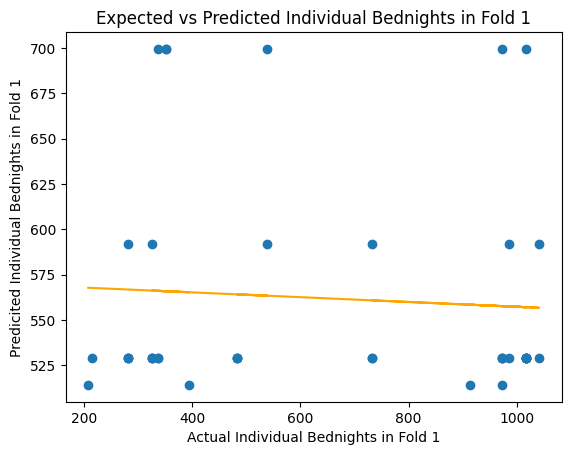

Fold 1 - MSE: 113545.5011, RMSE: 336.9651, R^2: -0.14178919035145343


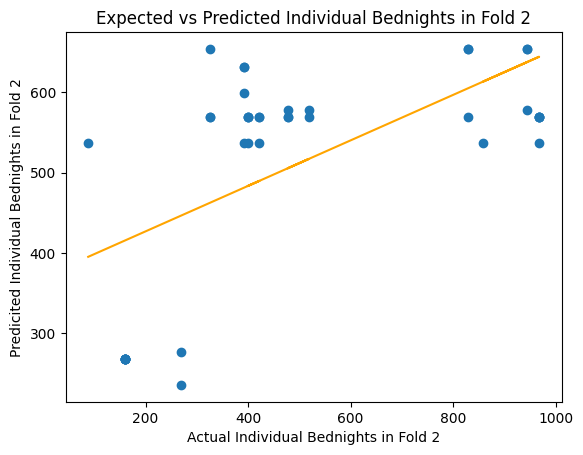

Fold 2 - MSE: 54709.0743, RMSE: 233.8997, R^2: 0.3458362104136351


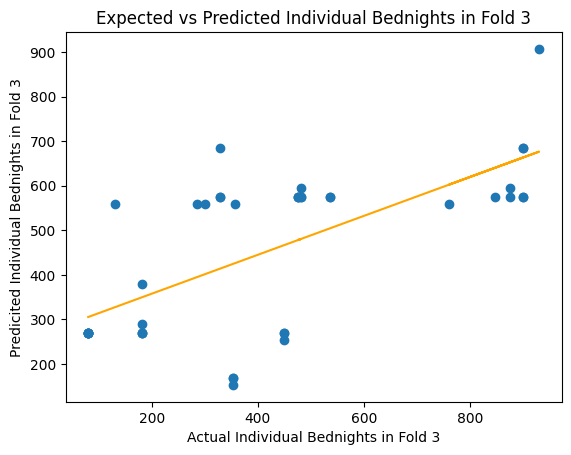

Fold 3 - MSE: 43200.9658, RMSE: 207.8484, R^2: 0.42511324854557997


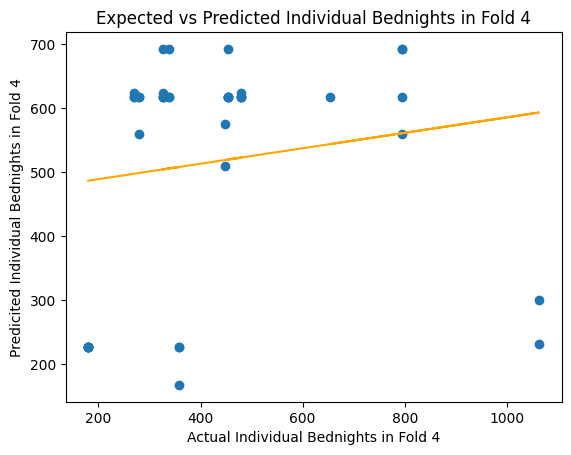

Fold 4 - MSE: 77104.1016, RMSE: 277.6763, R^2: -0.5731852415631142


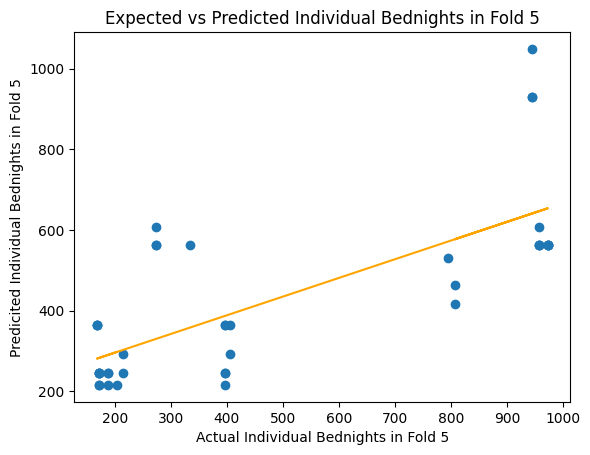

Fold 5 - MSE: 54943.6376, RMSE: 234.4006, R^2: 0.4974165603100843


<Figure size 640x480 with 0 Axes>

In [10]:
##Review new model using only HHSize and HHEmployed
x2 = reg1_dummies[['Disability','RegionCode_3','RegionCode_4', 'RegionCode_5','HHEmployed','SingleParent','Destination_2','Destination_4','Destination_6','Destination_7','Destination_9','Destination_10']]
y2 = reg1_dummies['Bednights']                           
groups2 = reg1_dummies['FamilyID']

gkf = GroupKFold(n_splits = 5)

##split the data in each fold
for fold, (train_idx, test_idx) in enumerate(gkf.split(x2, y2, groups2)):
    x_train, x_test = x2.iloc[train_idx], x2.iloc[test_idx]
    y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]

    ##train a model and predict target values for each fold
    model2 = LinearRegression()
    model2.fit(x_train, y_train)
    y_pred = model2.predict(x_test)

    ##compare predicted values and expected values for each model
    plt.scatter(y_test, y_pred)
    plt.xlabel(f'Actual Individual Bednights in Fold {fold+1}')
    plt.ylabel(f'Predicited Individual Bednights in Fold {fold+1}')
    plt.title(f'Expected vs Predicted Individual Bednights in Fold {fold+1}')
    a, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, a*(y_test)+b, color='orange')
    plt.show()
    plt.clf()

    ##Evaluate. The higher the mse & rmse, the worse the model. The lower and more negative the R^2 the worse the model
    ##the new models are very bad. they are equally bad from the stable RMSEs and the similar R^2s.
    set_config(enable_metadata_routing=False)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Fold {fold+1} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, R^2: {r2}')

Outcome: Linear Regression model and Sequential Fit Selector used to try to improve model. Model remains neutral to very bad. Will attempt Random Forest Regression.